<div class="alert alert-block alert-success">
    
    
# <center> Forecasting delays in warehouse deliveries </center>


<br>
    
</div>

<div class="alert alert-warning">
1.	The day of the week that has the maximum number of purchases made 
</div>

In [ ]:
import pystan
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly
import pandas as pd 
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima
from pmdarima.arima.utils import ndiffs

In [1]:

df = pd.read_csv(r'C:\Workbench\Transactions.csv')
df = df.dropna()
df['Delivery_Zip_Code'] = df['Delivery_Zip_Code'].astype(int)
df.head()


df2=pd.read_csv(r'C:\Users\waseb\Desktop\PurchasesLog.csv')




In [4]:
df=df.rename({'Delivery_Zip_Code' : 'DeliveryZipCode'}, axis=1)
df.head()

,CustomerID,FirstName,LastName,CreditCardNumber,OrderID,Customer_Occupation,Credit_Card_Number,Order_ID,Order_Date,Expected_Delivery_Date,...,Product_Name,Category,Manufacturer,Review_Rating,Delivery_Tracking_ID,Delivery_Type,DeliveryZipCode,Transaction_Status,Order_Returned,Order_Delivered_on_Time
0,566-26-0321,Rebeka,Stokes,xxxx-xxxx-xxxx-2650,50787284-d78d-4b6a-b93f-7419b0d46590,Lawyer,12345789032,98,4/7/2020,4/11/2020,...,Fitbit small,fitness,Fitbit small,3,98,Pickup,10048,Disputed,1,1
1,274-18-0017,Rahsaan,Koch,xxxx-xxxx-xxxx-5055,f61639d7-28de-4507-a63a-71e99921d8f9,Lawyer,12345789032,131,5/10/2020,5/14/2020,...,Fitbit small,fitness,Fitbit small,3,131,Pickup,10048,Disputed,1,1
2,455-28-7950,Zion,Osinski,xxxx-xxxx-xxxx-0150,7b1caf69-bd5b-441c-9115-6fa31ba1c313,Lawyer,12345789032,318,11/13/2020,11/17/2020,...,Fitbit small,fitness,Fitbit small,3,318,Pickup,10048,Disputed,1,1
3,254-72-5938,Ward,Brekke,xxxx-xxxx-xxxx-5280,cb58e8e9-572b-4d9e-af9f-dbecf9dfd3c5,Actor,12345789032,528,2/12/2020,2/16/2020,...,Fitbit large,fitness,Fitbit large,5,528,Pickup,10048,Disputed,0,1
4,563-47-8401,Terrence,Franecki,xxxx-xxxx-xxxx-1019,a9d66460-a48f-419f-8d39-7818290a3041,Actor,12345789032,561,2/12/2020,2/16/2020,...,Fitbit large,fitness,Fitbit large,5,561,Pickup,10048,Disputed,0,1


In [7]:
df3=df2[['DeliveryZipCode','DistributionCenterIDInSupplyChainNet','WarehouseIDInSupplyChainNet']]

In [9]:
df3=df3.dropna()

In [11]:
df3 = df3.astype({"DeliveryZipCode":int})

In [13]:
df3dropped = df3.drop_duplicates()

In [14]:
df4 = pd.merge(df, df3dropped, on=['DeliveryZipCode'])

In [16]:
uniqueware= df4['WarehouseIDInSupplyChainNet'].unique()
uniqueware

array(['Warehouse_4', 'Warehouse_5', 'Warehouse_17', 'Warehouse_16',
       'Warehouse_15', 'Warehouse_2', 'Warehouse_3', 'Warehouse_1',
       'Warehouse_19', 'Warehouse_18', 'Warehouse_13', 'Warehouse_12'],
      dtype=object)

In [17]:
uniquedist= df4['DistributionCenterIDInSupplyChainNet'].unique()
uniquedist

array(['DistributionCenter_13', 'DistributionCenter_14',
       'DistributionCenter_93', 'DistributionCenter_51',
       'DistributionCenter_50', 'DistributionCenter_85',
       'DistributionCenter_86', 'DistributionCenter_84',
       'DistributionCenter_2', 'DistributionCenter_66',
       'DistributionCenter_65', 'DistributionCenter_38',
       'DistributionCenter_37'], dtype=object)

In [18]:
uniqueproduct=df['Product_Name'].unique()
uniqueproduct

array(['Fitbit small', 'Fitbit large', 'Samsung s10', 'Redmi', 'Bose',
       'JBL', 'Harman Kardon', 'Sony', 'Logitech', 'VR7'], dtype=object)

In [19]:
df4[2000:2050]

,CustomerID,FirstName,LastName,CreditCardNumber,OrderID,Customer_Occupation,Credit_Card_Number,Order_ID,Order_Date,Expected_Delivery_Date,...,Manufacturer,Review_Rating,Delivery_Tracking_ID,Delivery_Type,DeliveryZipCode,Transaction_Status,Order_Returned,Order_Delivered_on_Time,DistributionCenterIDInSupplyChainNet,WarehouseIDInSupplyChainNet
2000,286-99-5507,Leonel,Hackett,xxxx-xxxx-xxxx-6681,ceb838f9-57ba-446c-a1db-4f7f92880aa0,Lawyer,12345789032,4528,12/22/2019,12/26/2019,...,Fitbit small,3,4528,Pickup,10168,Disputed,1,1,DistributionCenter_13,Warehouse_4
2001,279-87-8202,Royce,Gottlieb,xxxx-xxxx-xxxx-1875,128aa1b1-113e-418b-b9b8-60aded330fa7,Actor,12345789032,4748,8/1/2018,8/5/2018,...,Fitbit large,5,4748,Pickup,10168,Disputed,0,1,DistributionCenter_13,Warehouse_4
2002,765-33-6323,Dell,Gerhold,xxxx-xxxx-xxxx-7099,f341425a-4e09-4242-8ffb-16921024c39e,Actor,12345789032,4883,12/14/2018,12/18/2018,...,Fitbit large,5,4883,Pickup,10168,Disputed,0,1,DistributionCenter_13,Warehouse_4
2003,199-48-1296,Margret,Smith,xxxx-xxxx-xxxx-4060,b296894e-cb43-459b-905b-49437980cd0e,Actor,12345789032,4967,3/1/2018,3/5/2018,...,Fitbit large,5,4967,Pickup,10168,Disputed,0,1,DistributionCenter_13,Warehouse_4
2004,742-07-3462,Minnie,Baumbach,xxxx-xxxx-xxxx-1823,412031bf-50f4-4939-860e-df358e1eec01,Lawyer,12345789032,5275,11/5/2018,11/9/2018,...,Fitbit small,3,5275,Pickup,10168,Disputed,1,1,DistributionCenter_13,Warehouse_4
2005,038-42-7257,Colt,Baumbach,xxxx-xxxx-xxxx-7645,0ef2b89e-d63f-43a9-9502-1d6c9668f99f,Lawyer,12345789032,5705,9/19/2020,9/23/2020,...,Fitbit small,3,5705,Pickup,10168,Disputed,1,1,DistributionCenter_13,Warehouse_4
2006,777-07-8689,Noelia,Schneider,xxxx-xxxx-xxxx-9864,bf2b2581-36a2-4d32-85fb-9c95081be4ba,Actor,12345789032,5794,12/17/2020,12/21/2020,...,Fitbit large,5,5794,Pickup,10168,Disputed,0,1,DistributionCenter_13,Warehouse_4
2007,717-56-8051,Shania,Frami,xxxx-xxxx-xxxx-0433,73dc7483-eb85-472a-9c78-7da9e5a0ece4,Actor,12345789032,5827,1/2/2020,1/6/2020,...,Fitbit large,5,5827,Pickup,10168,Disputed,0,1,DistributionCenter_13,Warehouse_4
2008,593-61-2224,Keaton,Schuppe,xxxx-xxxx-xxxx-0881,a262bcbb-d266-4f93-b612-89428522560d,Actor,12345789032,6014,2/5/2020,2/9/2020,...,Fitbit large,5,6014,Pickup,10168,Disputed,0,1,DistributionCenter_13,Warehouse_4
2009,393-11-1206,Karianne,Farrell,xxxx-xxxx-xxxx-9577,b8ad7dbc-a83e-4822-9913-13a4f44c6d33,Lawyer,12345789032,6541,7/11/2019,7/15/2019,...,Fitbit small,3,6541,Pickup,10168,Disputed,1,1,DistributionCenter_13,Warehouse_4


In [85]:
df = pd.read_csv(r'C:\Workbench\Transactionsfinal.csv')

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16372 entries, 0 to 16371
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CustomerID                            16372 non-null  object 
 1   FirstName                             16372 non-null  object 
 2   LastName                              16372 non-null  object 
 3   CreditCardNumber                      16372 non-null  object 
 4   OrderID                               16372 non-null  object 
 5   Customer_Occupation                   16372 non-null  object 
 6   Credit_Card_Number                    16372 non-null  int64  
 7   Order_ID                              16372 non-null  int64  
 8   Order_Date                            16372 non-null  object 
 9   Expected_Delivery_Date                16372 non-null  object 
 10  Actual_Delivery_Date                  16372 non-null  object 
 11  Product_ID     

In [88]:
df=df[["DistributionCenterIDInSupplyChainNet","WarehouseIDInSupplyChainNet","CustomerID","FirstName","LastName","CreditCardNumber","Customer_Occupation","Order_ID","Expected_Delivery_Date","Actual_Delivery_Date","Order_Date","Product_ID","Delivery_Type","Review_Rating","Delivery_Zip_Code","Transaction_Status","Order_Returned","Order_Delivered_on_Time","Department","Category.1","ItemPurchased","Quantity","Price","ShippingCost","Discount","Sales","Profit"]]

In [89]:
df['Expected_Delivery_Date'] = pd.to_datetime(df['Expected_Delivery_Date'])
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Actual_Delivery_Date'] = pd.to_datetime(df['Actual_Delivery_Date'])
df.set_index('Actual_Delivery_Date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['week_of_year'] = df.index.weekofyear
df['day_of_week'] = df.index.dayofweek

In [90]:
df['day_of_week'] = df.index.dayofweek

In [29]:
df9=df.groupby('day_of_week')['Quantity'].sum()
df9

day_of_week
0    6238
1    6716
2    6814
3    7469
4    7833
5    7535
6    6776
Name: Quantity, dtype: int64

In [32]:
df9=df9.to_frame()
df9=df9.sort_values("Quantity",ascending=False)
df9[:8]

,Quantity
day_of_week,
4,7833
5,7535
3,7469
2,6814
6,6776
1,6716
0,6238


<div class="alert alert-warning">
2.	The month of the year that has the highest sales revenue
</div>

In [31]:
df10=df.groupby('month')['Sales'].sum()
df10=df10.to_frame()
df10=df10.sort_values("Sales",ascending=False)
df10[:12]

,Sales
month,
1,2253598.29
2,2092807.24
7,1532975.54
12,1514209.06
3,1266135.89
11,1236373.65
6,1221198.24
8,1017293.50
10,972031.05


<div class="alert alert-warning">
3.	The weekly sales revenue forecast per zip-code
</div>

In [130]:
weekly_df_sales = df.groupby(['Expected_Delivery_Date','week_of_year','Delivery_Zip_Code'])['Sales'].sum().reset_index(name ='weeklysaleperzip')
#weekly_df_sales=weekly_df_sales[weekly_df_sales["WarehouseIDInSupplyChainNet"]=='Warehouse_1']
weekly_df_sales=weekly_df_sales[['Expected_Delivery_Date','weeklysaleperzip']]

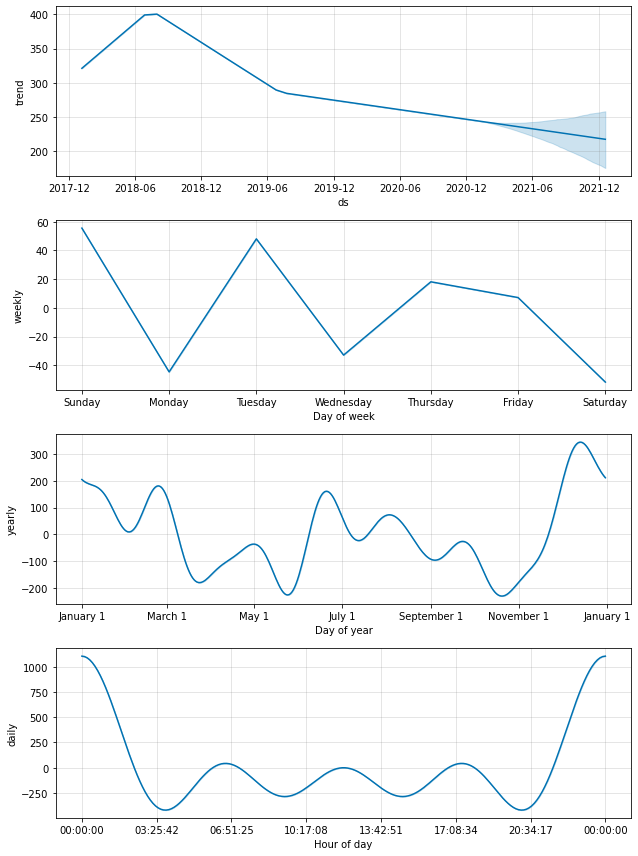

In [132]:

df11=df10
f11=df.groupby('Delivery_Zip_Code')['Sales'].sum().reset_index(name='Sales')

weekly_df_sales = weekly_df_sales.rename(columns = {'Expected_Delivery_Date': 'ds',
                                'weeklysaleperzip': 'y'})
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(weekly_df_sales) 
future_dates = model.make_future_dataframe(periods = 50, freq='W')
forecast = model.predict(future_dates)
model.plot_components(forecast);


<div class="alert alert-warning">
4.	The daily number of purchases forecast per distribution center

</div>

In [127]:
dist=df['DistributionCenterIDInSupplyChainNet'].unique()
dist

array(['DistributionCenter_13', 'DistributionCenter_93',
       'DistributionCenter_51', 'DistributionCenter_50',
       'DistributionCenter_86', 'DistributionCenter_2',
       'DistributionCenter_66', 'DistributionCenter_65',
       'DistributionCenter_38', 'DistributionCenter_37',
       'DistributionCenter_14', 'DistributionCenter_85',
       'DistributionCenter_84'], dtype=object)

In [158]:
weekly_df_sales = df.groupby(['Expected_Delivery_Date','day','DistributionCenterIDInSupplyChainNet'])['Quantity'].sum().reset_index(name ='Daily_Order')
weekly_df_sales13=weekly_df_sales[weekly_df_sales["DistributionCenterIDInSupplyChainNet"]=='DistributionCenter_13']

In [159]:
weekly_df_sales

,Expected_Delivery_Date,day,DistributionCenterIDInSupplyChainNet,Daily_Order
0,2018-01-05,9,DistributionCenter_14,3
1,2018-01-05,9,DistributionCenter_2,4
2,2018-01-05,9,DistributionCenter_37,8
3,2018-01-05,9,DistributionCenter_38,5
4,2018-01-05,9,DistributionCenter_51,8
...,...,...,...,...
6668,2021-01-04,8,DistributionCenter_51,6
6669,2021-01-04,8,DistributionCenter_65,10
6670,2021-01-04,8,DistributionCenter_66,3
6671,2021-01-04,8,DistributionCenter_86,4


In [188]:
def function():
    listattempt=['DistributionCenter_13', 'DistributionCenter_93',
       'DistributionCenter_51', 'DistributionCenter_50',
       'DistributionCenter_86', 'DistributionCenter_2',
       'DistributionCenter_66', 'DistributionCenter_65',
       'DistributionCenter_38', 'DistributionCenter_37',
       'DistributionCenter_14', 'DistributionCenter_85',
       'DistributionCenter_84']
    output=[]
    #while True:
    for i in listattempt:
        weekly_df_sales = df.groupby(['Expected_Delivery_Date','day','DistributionCenterIDInSupplyChainNet'])['Quantity'].sum().reset_index(name ='Daily_Order')
        weekly_df_sales=weekly_df_sales[weekly_df_sales["DistributionCenterIDInSupplyChainNet"]== i]
        weekly_df_sales=weekly_df_sales[['Expected_Delivery_Date','Daily_Order']]
        weekly_df_sales = weekly_df_sales.rename(columns = {'Expected_Delivery_Date': 'ds',
                                'Daily_Order': 'y'})
        model = Prophet(yearly_seasonality=False, daily_seasonality=False)
        model.fit(weekly_df_sales) 
        future_dates = model.make_future_dataframe(periods = 50, freq='D')
        forecast = model.predict(future_dates)
        plot_plotly(model, forecast)
        forecast=forecast[['ds','trend']]
        print(forecast)
        output.append(forecast)
        
        
    
    
        
    


In [189]:
function()

            ds     trend
0   2018-01-08  9.352638
1   2018-01-09  9.351034
2   2018-01-10  9.349430
3   2018-01-12  9.346222
4   2018-01-13  9.344618
..         ...       ...
773 2021-02-19  7.528421
774 2021-02-20  7.526819
775 2021-02-21  7.525217
776 2021-02-22  7.523615
777 2021-02-23  7.522012

[778 rows x 2 columns]
            ds     trend
0   2018-01-06  5.340328
1   2018-01-08  5.340669
2   2018-01-09  5.340839
3   2018-01-10  5.341009
4   2018-01-11  5.341179
..         ...       ...
412 2021-02-19  5.481454
413 2021-02-20  5.481567
414 2021-02-21  5.481681
415 2021-02-22  5.481794
416 2021-02-23  5.481908

[417 rows x 2 columns]
            ds     trend
0   2018-01-05  8.203398
1   2018-01-06  8.203802
2   2018-01-08  8.204610
3   2018-01-09  8.205014
4   2018-01-10  8.205418
..         ...       ...
783 2021-02-19  8.664132
784 2021-02-20  8.664536
785 2021-02-21  8.664939
786 2021-02-22  8.665343
787 2021-02-23  8.665747

[788 rows x 2 columns]
            ds     trend
0  

<div class="alert alert-warning">
5.	The weekly number of product returns forecast per warehouse
    
</div>

In [191]:
warehouses=df['WarehouseIDInSupplyChainNet'].unique()
warehouses

array(['Warehouse_4', 'Warehouse_17', 'Warehouse_16', 'Warehouse_15',
       'Warehouse_3', 'Warehouse_1', 'Warehouse_19', 'Warehouse_18',
       'Warehouse_13', 'Warehouse_12', 'Warehouse_5', 'Warehouse_2'],
      dtype=object)

In [229]:
def function():
    listattempt=['Warehouse_4', 'Warehouse_17', 'Warehouse_16', 'Warehouse_15',
       'Warehouse_3', 'Warehouse_1', 'Warehouse_19', 'Warehouse_18',
       'Warehouse_13', 'Warehouse_12', 'Warehouse_5', 'Warehouse_2']
    output=[]
    #while True:
    for i in listattempt:
        weekly_df_returns = df.groupby(['Expected_Delivery_Date','week_of_year','WarehouseIDInSupplyChainNet'])['Order_Returned'].sum().reset_index(name ='Weekly_Returns')
        weekly_df_returns=weekly_df_returns[weekly_df_returns['WarehouseIDInSupplyChainNet']== i]
        weekly_df_returns=weekly_df_returns[['Expected_Delivery_Date','Weekly_Returns']]
        weekly_df_returns =weekly_df_returns.rename(columns = {'Expected_Delivery_Date': 'ds',
                                'Weekly_Returns': 'y'})
        model = Prophet(yearly_seasonality=False, daily_seasonality=False)
        model.fit(weekly_df_returns) 
        future_dates = model.make_future_dataframe(periods =10 , freq='w')
        forecast = model.predict(future_dates)
        
        model.plot(forecast);




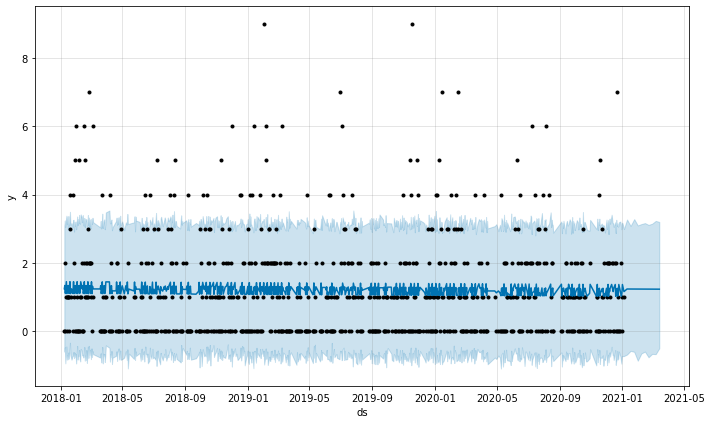

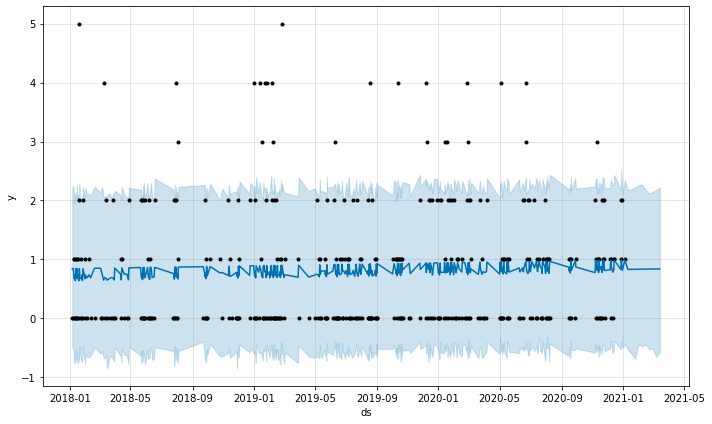

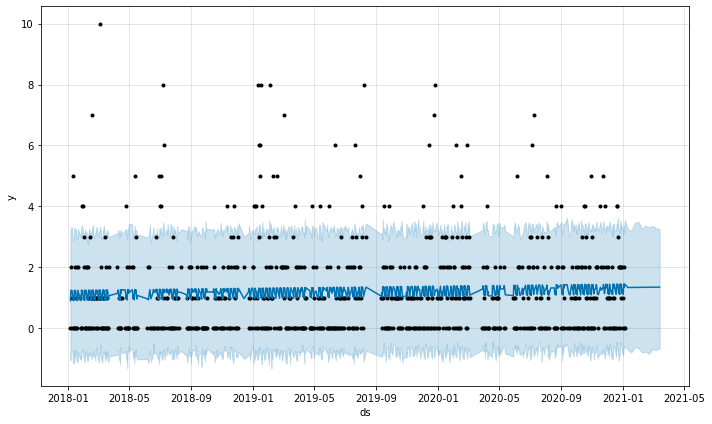

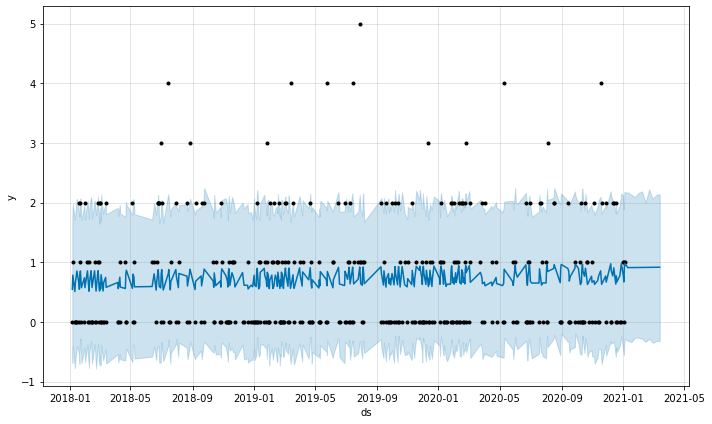

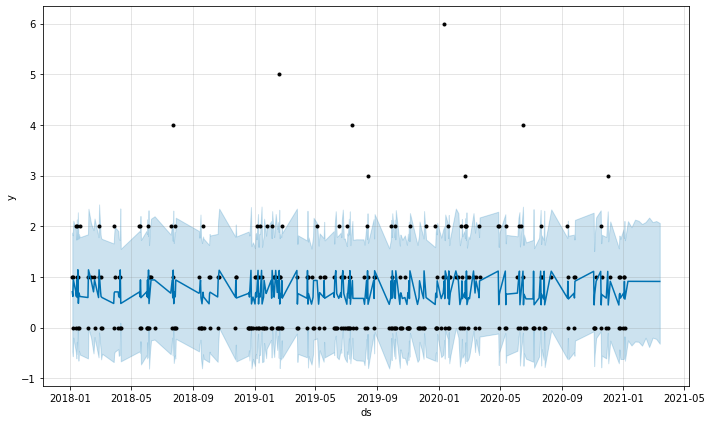

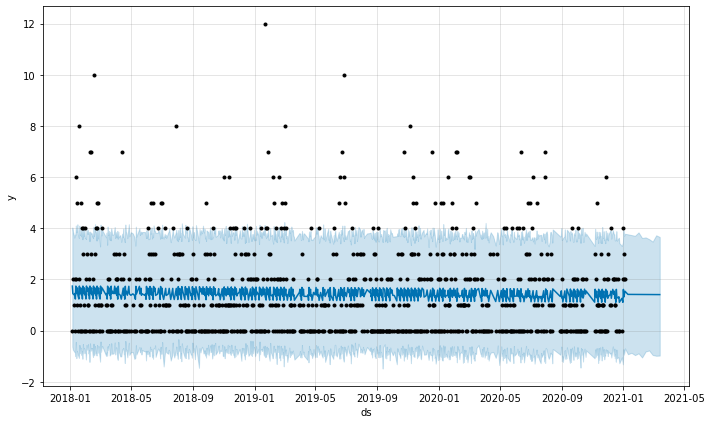

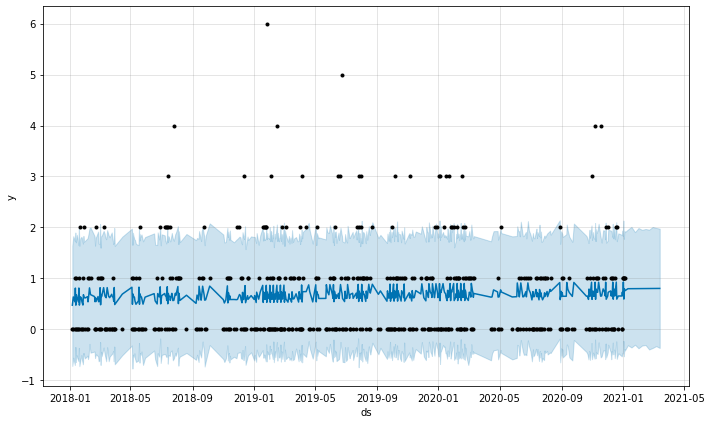

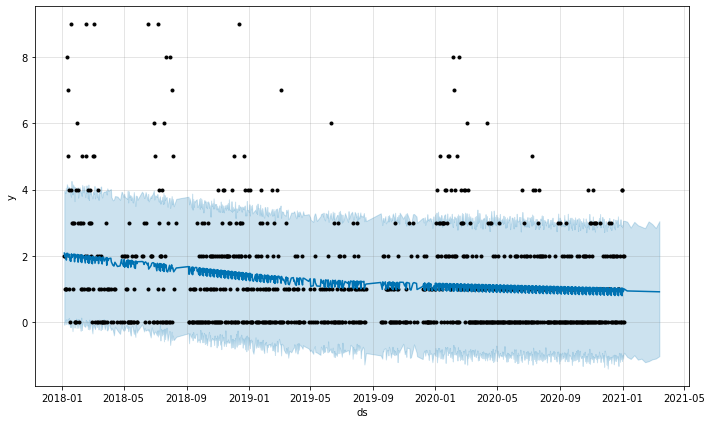

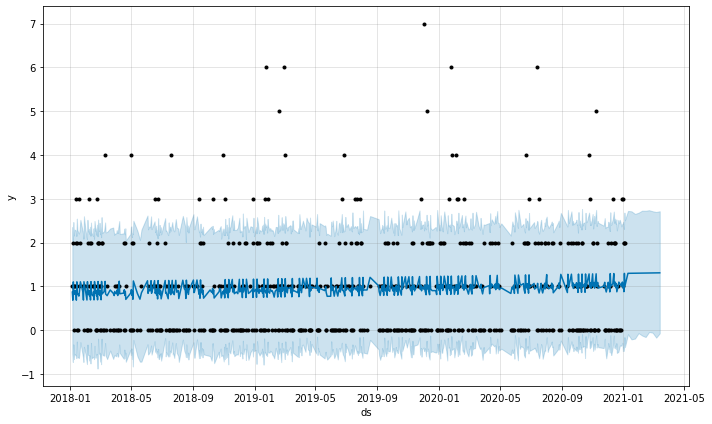

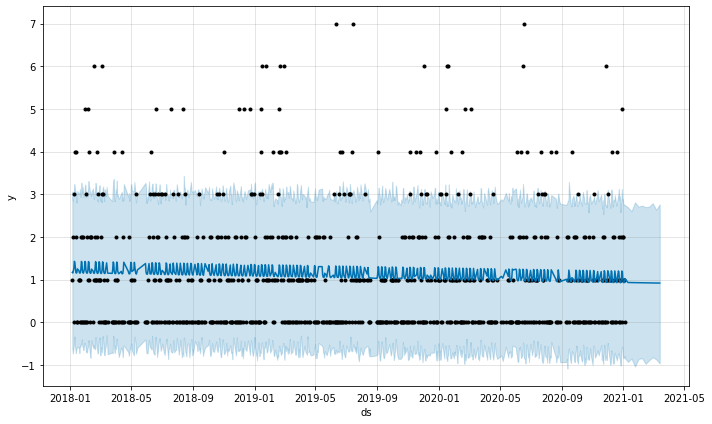

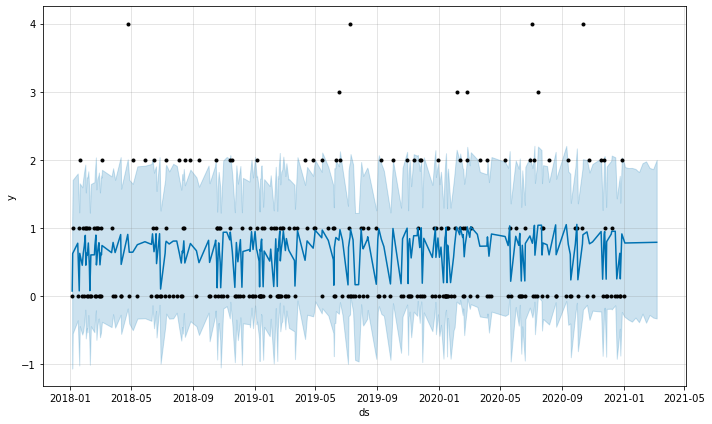

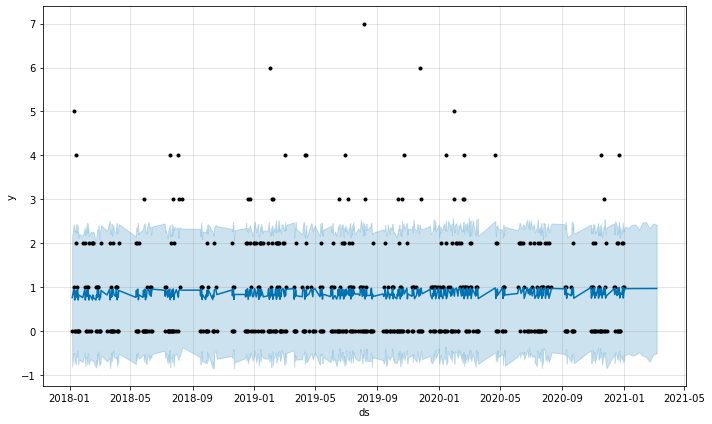

In [230]:
function()

<div class="alert alert-warning">
6.	Whether the number of delayed deliveries per zip-code positively correlated to the number of returned purchases/products.    
</div>

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16372 entries, 2021-01-08 to 2018-01-09
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   DistributionCenterIDInSupplyChainNet  16372 non-null  object        
 1   WarehouseIDInSupplyChainNet           16372 non-null  object        
 2   CustomerID                            16372 non-null  object        
 3   FirstName                             16372 non-null  object        
 4   LastName                              16372 non-null  object        
 5   CreditCardNumber                      16372 non-null  object        
 6   Customer_Occupation                   16372 non-null  object        
 7   Order_ID                              16372 non-null  int64         
 8   Expected_Delivery_Date                16372 non-null  datetime64[ns]
 9   Order_Date                            16372 non-null  d

In [248]:
correlationdf = df.groupby[('Delivery_Zip_Code')][['Order_Returned','Order_Delivered_on_Time']].sum()

In [251]:
correlationdf.head()

,Order_Returned,Order_Delivered_on_Time
Delivery_Zip_Code,,
10048,187,293
10110,167,285
10121,159,281
10123,198,320
10168,171,293


In [250]:
correlationdf.describe()

,Order_Returned,Order_Delivered_on_Time
count,62.000000,62.000000
mean,114.177419,191.645161
std,93.631913,155.144787
min,9.000000,16.000000
25%,66.000000,113.000000
50%,91.500000,149.000000
75%,165.000000,272.500000
max,684.000000,1148.000000


In [252]:
x=correlationdf['Order_Returned']
x=x.to_numpy()
y=correlationdf['Order_Delivered_on_Time']
y=y.to_numpy()

In [253]:
import scipy.stats
scipy.stats.spearmanr(x, y)

SpearmanrResult(correlation=0.9720539563987473, pvalue=1.8202486619878248e-39)

In [255]:
correlationdf2 = df.groupby(['Expected_Delivery_Date','Delivery_Zip_Code'])[['Order_Returned','Order_Delivered_on_Time']].sum()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017349CE3F48>,
      dtype=object)

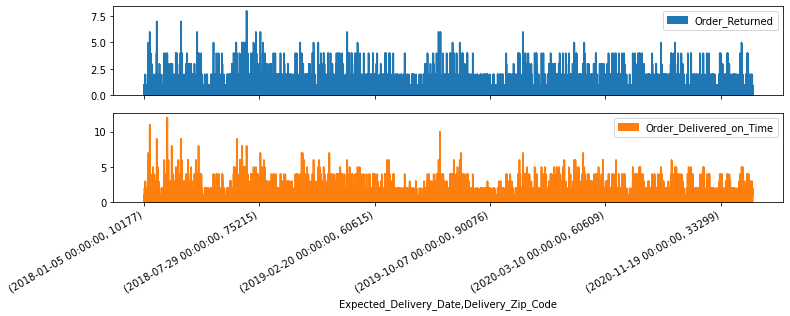

In [261]:
axs = correlationdf2.plot.area(figsize=(12, 4), subplots=True)
axs

<div class="alert alert-warning">
7.	The busiest zip code (counting both deliveries and purchase returns)
</div>

In [282]:
correlationdf = df.groupby('Delivery_Zip_Code')[['Order_Returned','Order_Delivered_on_Time']].sum()
busy=correlationdf['Order_Returned']+correlationdf['Order_Delivered_on_Time']
busy=busy.to_frame()
busy.info()
busy['total']=busy[0]
busy.sort_values('total',ascending=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 10048 to 90774
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       62 non-null     int64
dtypes: int64(1)
memory usage: 992.0 bytes


,0,total
Delivery_Zip_Code,,
75215,1832,1832
60663,545,545
60623,540,540
60615,537,537
60660,533,533
...,...,...
31192,70,70
39901,47,47
30365,32,32


<div class="alert alert-warning">
8.	The most selling product in every zip-code
</div>

In [357]:
mostsold

,Delivery_Zip_Code,ItemPurchased,Total_Number_of_orders_per_zip
0,10048,1TB Portable External Hard Drive,1
1,10048,ACCOHIDE Binder - Blue - 1,2
2,10048,AMS Bowfishing Crossbow Carp Kit - Right Hand,5
3,10048,Allen Solly Groomed T-Shirt,3
4,10048,Allen Solly White Shorts,1
...,...,...,...
6804,90774,Whiteboard Marker Set - 10 pcs,3
6805,90774,Wonderful Pistachios Roasted,8
6806,90774,Workwear Pocket T-Shirt,4
6807,90774,Zoho Wireless Scanner - Automatic,3


In [356]:
mostsold = df.groupby(['Delivery_Zip_Code','ItemPurchased'])['ItemPurchased'].count().reset_index(name ='Total_Number_of_orders_per_zip')
mostsold10048=mostsold[mostsold['Delivery_Zip_Code']==10048]
mostsold10048.loc[mostsold10048['Total_Number_of_orders_per_zip'].idxmax()]

Delivery_Zip_Code                                       10048
ItemPurchased                     Under Armour Men's HeatGear
Total_Number_of_orders_per_zip                             13
Name: 139, dtype: object

In [378]:

def function():
    listattempt=[10048, 10110, 10121, 10123, 10168, 10177, 30306, 30328, 30336,30365, 30369, 30381, 30386, 31191, 31192, 33111, 33127, 33152,33153, 33175, 33187, 33242, 33247, 33269, 33299, 37206, 37209,37210, 37213, 37227, 37228, 37237, 37240, 37250, 39901, 60535,60609, 60615, 60622, 60623, 60660, 60663, 75210, 75214, 75215,75231, 75246, 75251, 75363, 75368, 75373, 75379, 75382, 90032,90051, 90060, 90062, 90076, 90077, 90080, 90097, 90774]
    output=[]
    #while True:
    for i in listattempt:
        
        mostsold=df.groupby(['Delivery_Zip_Code','ItemPurchased'])['ItemPurchased'].count().reset_index(name ='Total_Number_of_orders_per_zip')
        mostsold=mostsold[mostsold['Delivery_Zip_Code']==i]
        mostpopular=mostsold.loc[mostsold['Total_Number_of_orders_per_zip'].idxmax()]
        print(mostpopular)
        
      


In [379]:
function()

Delivery_Zip_Code                                       10048
ItemPurchased                     Under Armour Men's HeatGear
Total_Number_of_orders_per_zip                             13
Name: 139, dtype: object
Delivery_Zip_Code                                                     10110
ItemPurchased                     Callaway Golf 2021 REVA Complete Golf Set
Total_Number_of_orders_per_zip                                           13
Name: 166, dtype: object
Delivery_Zip_Code                                       10121
ItemPurchased                     Under Armour Men's HeatGear
Total_Number_of_orders_per_zip                             12
Name: 417, dtype: object
Delivery_Zip_Code                                                   10123
ItemPurchased                     TaylorMade Golf Kalea Complete Golf Set
Total_Number_of_orders_per_zip                                         14
Name: 565, dtype: object
Delivery_Zip_Code                                       10168
ItemPurchased   

<div class="alert alert-warning">
9.	Analyze whether the sales of the Electronics department  and  the Clothing department have similar seasonal patterns
</div>

In [397]:
weekly_df_returns = df.groupby(['Expected_Delivery_Date','week_of_year','Department'])['Quantity'].sum().reset_index(name ='Weekly_Returns')
weekly_df_returns=weekly_df_returns[weekly_df_returns['Department']== 'Electronics']

weekly_df_returns =weekly_df_returns.rename(columns = {'Expected_Delivery_Date': 'ds',
                                'Weekly_Returns': 'y'})
model = Prophet(yearly_seasonality=False,daily_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(weekly_df_returns) 
future_dates = model.make_future_dataframe(periods =10 , freq='w')
forecast = model.predict(future_dates)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-05,9.883125,-0.356357,18.479093,9.883125,9.883125,-0.682913,-0.682913,-0.682913,0.004428,0.004428,0.004428,-0.687341,-0.687341,-0.687341,0.0,0.0,0.0,9.200212
1,2018-01-06,9.883378,-1.380272,18.135662,9.883378,9.883378,-0.515579,-0.515579,-0.515579,-0.601663,-0.601663,-0.601663,0.086084,0.086084,0.086084,0.0,0.0,0.0,9.367799
2,2018-01-07,9.883631,-0.396157,17.944772,9.883631,9.883631,-0.828960,-0.828960,-0.828960,-1.038014,-1.038014,-1.038014,0.209053,0.209053,0.209053,0.0,0.0,0.0,9.054671
3,2018-01-08,9.883884,0.457843,18.675486,9.883884,9.883884,-0.598963,-0.598963,-0.598963,-1.003001,-1.003001,-1.003001,0.404039,0.404039,0.404039,0.0,0.0,0.0,9.284921
4,2018-01-09,9.884137,0.998323,20.252699,9.884137,9.884137,0.680564,0.680564,0.680564,-0.584447,-0.584447,-0.584447,1.265010,1.265010,1.265010,0.0,0.0,0.0,10.564701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,2021-02-14,9.538470,-0.449180,18.206842,9.537893,9.539053,-0.667703,-0.667703,-0.667703,-0.876757,-0.876757,-0.876757,0.209053,0.209053,0.209053,0.0,0.0,0.0,8.870767
848,2021-02-21,9.536241,-0.903327,18.561053,9.535398,9.537064,-0.620715,-0.620715,-0.620715,-0.829769,-0.829769,-0.829769,0.209053,0.209053,0.209053,0.0,0.0,0.0,8.915526
849,2021-02-28,9.534011,-0.667220,18.649585,9.532919,9.535087,-0.677423,-0.677423,-0.677423,-0.886477,-0.886477,-0.886477,0.209053,0.209053,0.209053,0.0,0.0,0.0,8.856588
850,2021-03-07,9.531782,0.893798,19.863287,9.530426,9.533081,0.791436,0.791436,0.791436,0.582383,0.582383,0.582383,0.209053,0.209053,0.209053,0.0,0.0,0.0,10.323218


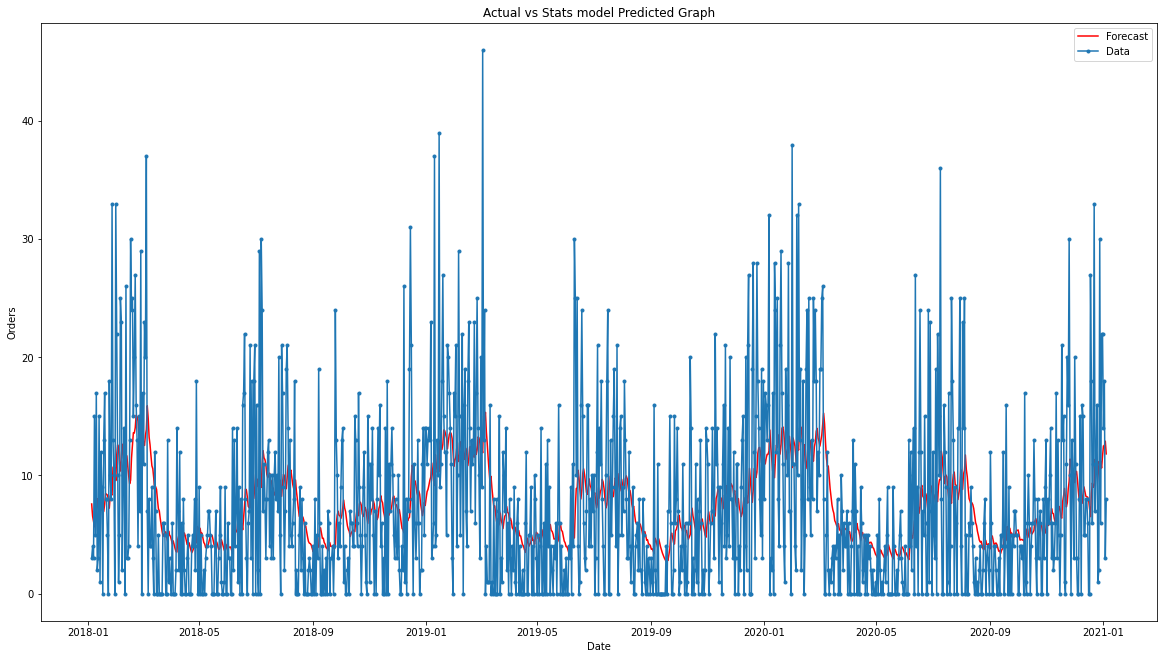

In [410]:
lzip = lambda *x:list(zip(*x))

days = weekly_df_returns.groupby('ds')['ds'].value_counts()
Y = weekly_df_returns['y'].values
X = lzip(*days.index.values)[0]
firstDay = min(X)

# To achieve data consistancy with both actual data and predicted values, I'm adding zeros to dates that do not have orders 
Ys = [0,]*((max(X) - firstDay).days + 1)#[firstDay + timedelta(days=day) for day in range((max(X) - firstDay).days + 1)]
days = pd.Series([firstDay + timedelta(days=i) for i in range(len(Ys))])
for x, y in zip(X, Y):
    Ys[(x - firstDay).days] = y
# parameters of the stats model is based on the below two graphs
est = sm.tsa.ARIMA(Ys, order=(1,0,1)).fit()
yHat = est.fittedvalues
 
fig, axs = plt.subplots(1, 1, figsize=(20, 11))
X = mdates.date2num(days)
axs.plot(X, yHat, c='red', label='Forecast')
axs.plot(X, Ys, marker='.', label='Data')
locator = mdates.AutoDateLocator()
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
axs.legend()
axs.set_title('Actual vs Stats model Predicted Graph')
axs.set_xlabel('Date')
axs.set_ylabel('Orders')
plt.show()

In [412]:
weekly_df_returns = df.groupby(['Expected_Delivery_Date','week_of_year','Department'])['Quantity'].sum().reset_index(name ='Daily_Purchases')
weekly_df_returns=weekly_df_returns[weekly_df_returns['Department']== 'Clothing']
weekly_df_returns =weekly_df_returns.rename(columns = {'Expected_Delivery_Date': 'ds',
                                'Daily_Purchases': 'y'})
model = Prophet(yearly_seasonality=False,daily_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(weekly_df_returns) 
future_dates = model.make_future_dataframe(periods =10 , freq='w')
forecast = model.predict(future_dates)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-05,9.756844,-0.048915,19.001432,9.756844,9.756844,-0.126022,-0.126022,-0.126022,0.498484,0.498484,0.498484,-0.624506,-0.624506,-0.624506,0.0,0.0,0.0,9.630821
1,2018-01-06,9.756369,-1.899064,18.683643,9.756369,9.756369,-1.248931,-1.248931,-1.248931,-0.265635,-0.265635,-0.265635,-0.983296,-0.983296,-0.983296,0.0,0.0,0.0,8.507438
2,2018-01-07,9.755894,-1.389348,18.737551,9.755894,9.755894,-0.940752,-0.940752,-0.940752,-0.875144,-0.875144,-0.875144,-0.065608,-0.065608,-0.065608,0.0,0.0,0.0,8.815142
3,2018-01-09,9.754944,-0.888965,20.162332,9.754944,9.754944,-0.111282,-0.111282,-0.111282,-0.800867,-0.800867,-0.800867,0.689585,0.689585,0.689585,0.0,0.0,0.0,9.643662
4,2018-01-10,9.754469,0.333771,20.168035,9.754469,9.754469,0.446725,0.446725,0.446725,-0.374109,-0.374109,-0.374109,0.820834,0.820834,0.820834,0.0,0.0,0.0,10.201194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,2021-02-14,9.177186,-0.145703,19.625087,9.177073,9.177294,0.228009,0.228009,0.228009,0.293617,0.293617,0.293617,-0.065608,-0.065608,-0.065608,0.0,0.0,0.0,9.405194
914,2021-02-21,9.173134,-1.174337,18.722699,9.172990,9.173275,-0.017292,-0.017292,-0.017292,0.048316,0.048316,0.048316,-0.065608,-0.065608,-0.065608,0.0,0.0,0.0,9.155842
915,2021-02-28,9.169083,-1.097534,18.809713,9.168898,9.169255,-0.382517,-0.382517,-0.382517,-0.316909,-0.316909,-0.316909,-0.065608,-0.065608,-0.065608,0.0,0.0,0.0,8.786566
916,2021-03-07,9.165031,0.003848,20.592468,9.164806,9.165254,0.920106,0.920106,0.920106,0.985714,0.985714,0.985714,-0.065608,-0.065608,-0.065608,0.0,0.0,0.0,10.085138


In [413]:
forecast.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.0,918.0,918.0,918.000000
mean,9.489853,-0.660951,19.650233,9.489852,9.489854,-0.006691,-0.006691,-0.006691,0.009565,0.009565,0.009565,-0.016256,-0.016256,-0.016256,0.0,0.0,0.0,9.483162
std,0.160803,1.069130,1.076559,0.160805,0.160801,0.973149,0.973149,0.973149,0.508046,0.508046,0.508046,0.815215,0.815215,0.815215,0.0,0.0,0.0,0.986277
min,9.160980,-3.559173,16.622582,9.160712,9.161249,-2.030216,-2.030216,-2.030216,-1.046920,-1.046920,-1.046920,-0.983296,-0.983296,-0.983296,0.0,0.0,0.0,7.240642
25%,9.361380,-1.438538,18.850433,9.361380,9.361380,-0.784160,-0.784160,-0.784160,-0.367671,-0.367671,-0.367671,-0.952982,-0.952982,-0.952982,0.0,0.0,0.0,8.698837
50%,9.494470,-0.727574,19.590792,9.494470,9.494470,0.004250,0.004250,0.004250,0.065790,0.065790,0.065790,-0.065608,-0.065608,-0.065608,0.0,0.0,0.0,9.448315
75%,9.625058,0.160317,20.508155,9.625058,9.625058,0.820361,0.820361,0.820361,0.332316,0.332316,0.332316,0.820834,0.820834,0.820834,0.0,0.0,0.0,10.308439
max,9.756844,2.411530,22.510412,9.756844,9.756844,2.173369,2.173369,2.173369,1.057395,1.057395,1.057395,1.115974,1.115974,1.115974,0.0,0.0,0.0,11.830510


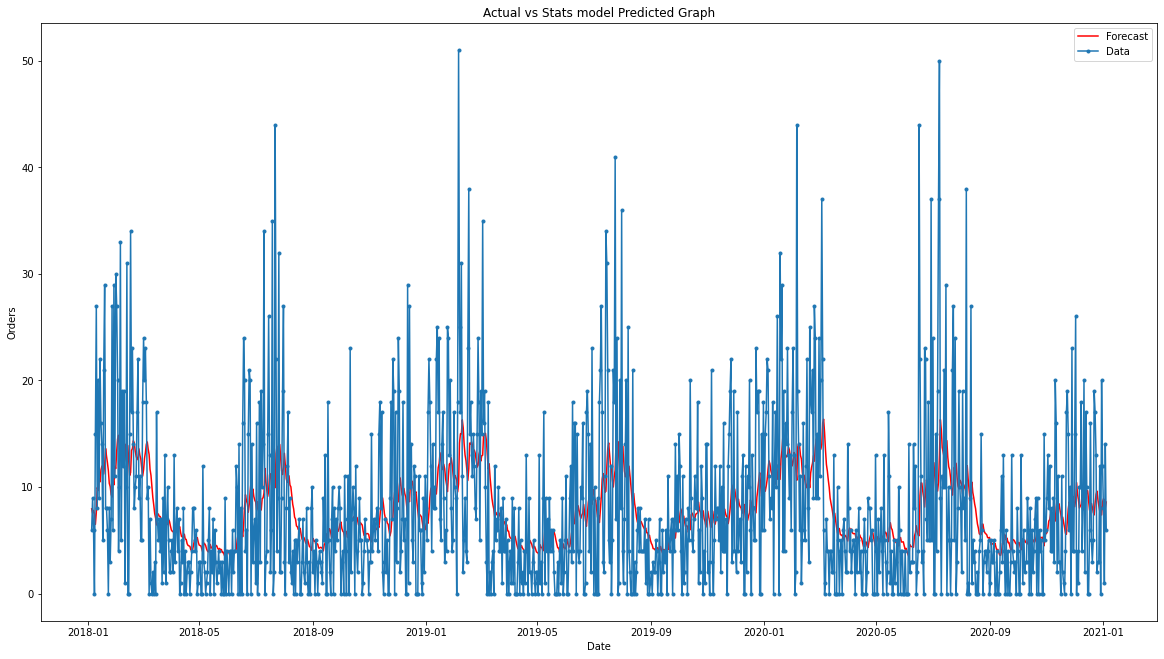

In [414]:
lzip = lambda *x:list(zip(*x))

days = weekly_df_returns.groupby('ds')['ds'].value_counts()
Y = weekly_df_returns['y'].values
X = lzip(*days.index.values)[0]
firstDay = min(X)

# To achieve data consistancy with both actual data and predicted values, I'm adding zeros to dates that do not have orders 
Ys = [0,]*((max(X) - firstDay).days + 1)
days = pd.Series([firstDay + timedelta(days=i) for i in range(len(Ys))])
for x, y in zip(X, Y):
    Ys[(x - firstDay).days] = y
# parameters of the stats model is based on the below two graphs
est = sm.tsa.ARIMA(Ys, order=(1,0,1)).fit()
yHat = est.fittedvalues
 
fig, axs = plt.subplots(1, 1, figsize=(20, 11))
X = mdates.date2num(days)
axs.plot(X, yHat, c='red', label='Forecast')
axs.plot(X, Ys, marker='.', label='Data')
locator = mdates.AutoDateLocator()
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
axs.legend()
axs.set_title('Actual vs Stats model Predicted Graph')
axs.set_xlabel('Date')
axs.set_ylabel('Orders')
plt.show()

<div class="alert alert-warning">
10.	Product purchases seasonality through the year; for example, Back-to-School, Christmas, Superbowl, Weather, etc.
</div>

In [418]:
import fbprophet
fbprophet.__version__

'0.7.1'

In [416]:
# Python
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
#df['nfl_sunday'] = df['ds'].apply(nfl_sunday)



In [ ]:
weekly_df_returns = df.groupby(['Expected_Delivery_Date','ItemPurchased'])['Quantity'].sum().reset_index(name ='Daily_Purchases')
weekly_df_returns =weekly_df_returns.rename(columns = {'Expected_Delivery_Date': 'ds',
                                'Daily_Purchases': 'y'})
weekly_df_returns['nfl_sunday'] = weekly_df_returns['ds'].apply(nfl_sunday)
model = Prophet(yearly_seasonality=False,daily_seasonality=False)
model.add_regresor('nfl_sunday')
model.fit(weekly_df_returns) 
future_dates = model.make_future_dataframe(periods =10 , freq='w')
forecast = model.predict(future_dates)
forecast

<div class="alert alert-warning">
11.	Build time series analysis model for product X (specify product)  in zip-code Y (specify zip code) to forecast daily sales revenue
</div>

In [423]:
weekly14=df.groupby(['Expected_Delivery_Date','ItemPurchased','Delivery_Zip_Code'])['Sales'].sum().reset_index(name='Daily_Purchases')
weekly14=weekly14[weekly14['Delivery_Zip_Code']==75215]

In [427]:
weekly14

,ds,y
12,2018-01-05,512.80
1127,2018-02-17,229.51
3421,2018-08-03,1619.41
11500,2020-01-28,785.01
11727,2020-02-06,506.89
12651,2020-03-22,284.56
12923,2020-04-26,208.19


In [426]:
weekly14=weekly14[weekly14['ItemPurchased']=='Poster Frame']
weekly14=weekly14[['Expected_Delivery_Date','Daily_Purchases']]
weekly14 =weekly14.rename(columns = {'Expected_Delivery_Date': 'ds',
                                'Daily_Purchases': 'y'})
model = Prophet(yearly_seasonality=False,daily_seasonality=False)
model.fit(weekly14) 
future_dates = model.make_future_dataframe(periods =10 , freq='w')
forecast = model.predict(future_dates)
forecast

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-05,751.240407,127.919564,1308.099186,751.240407,751.240407,0.0,0.0,0.0,0.0,0.0,0.0,751.240407
1,2018-02-17,737.179752,192.333617,1281.640258,737.179752,737.179752,0.0,0.0,0.0,0.0,0.0,0.0,737.179752
2,2018-08-03,682.572096,147.019989,1250.994409,682.572096,682.572096,0.0,0.0,0.0,0.0,0.0,0.0,682.572096
3,2020-01-28,505.015462,5.153020,1067.800858,505.015462,505.015462,0.0,0.0,0.0,0.0,0.0,0.0,505.015462
4,2020-02-06,502.072535,-96.830193,1005.556053,502.072535,502.072535,0.0,0.0,0.0,0.0,0.0,0.0,502.072535
5,2020-03-22,487.357896,-61.608109,1007.688895,487.357896,487.357896,0.0,0.0,0.0,0.0,0.0,0.0,487.357896
6,2020-04-26,475.913178,-72.590550,1016.383091,475.913178,475.913178,0.0,0.0,0.0,0.0,0.0,0.0,475.913178
7,2020-05-03,473.624234,-74.846989,1023.693816,473.624234,473.624234,0.0,0.0,0.0,0.0,0.0,0.0,473.624234
8,2020-05-10,471.335290,-73.032021,1046.411500,471.335290,471.335290,0.0,0.0,0.0,0.0,0.0,0.0,471.335290
9,2020-05-17,469.046347,-117.805166,1020.847425,469.046347,469.046347,0.0,0.0,0.0,0.0,0.0,0.0,469.046347


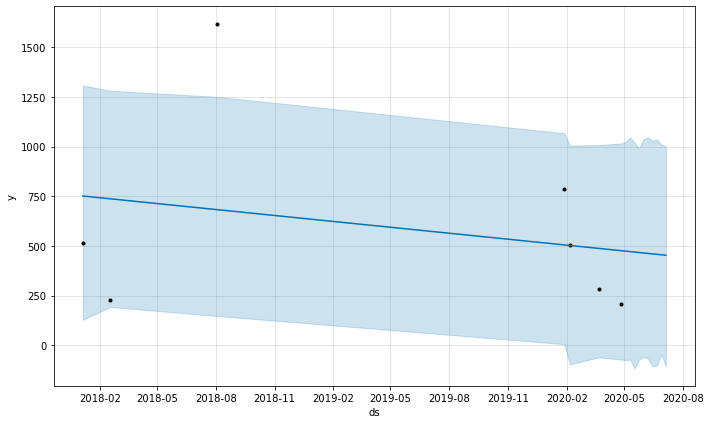

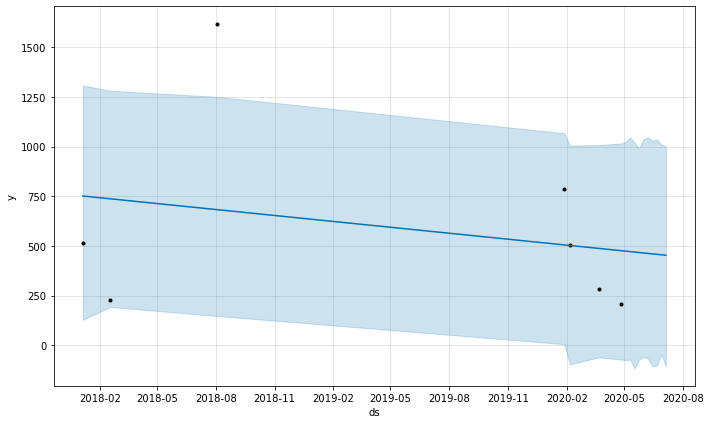

In [428]:
model.plot(forecast)